# NCAA ML Competition - Women's 2018

## Notes

Notes about what's in the data files: https://www.kaggle.com/c/womens-machine-learning-competition-2018/data

Starter Kernel might help: https://www.kaggle.com/juliaelliott/basic-starter-kernel-ncaa-women-s-dataset

In [368]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

In [369]:
df = pd.read_csv('WStage2DataFiles/WRegularSeasonDetailedResults.csv') ## regular season exploration
df_teams = pd.read_csv('./WStage2DataFiles/' + 'WTeams.csv')
df_leagues = pd.merge(left=df_teams, right=pd.read_csv('./WStage2DataFiles/' + 'WLeagues.csv'), how='left', on=['TeamName'])
df_leagues.head()


,TeamID,TeamName,LeagueName
0,3101,Abilene Chr,Southland
1,3102,Air Force,MWC
2,3103,Akron,MAC
3,3104,Alabama,SEC
4,3105,Alabama A&M,SWAC


In [370]:
df_winning_team_leagues = df_leagues
df_winning_team_leagues = df_winning_team_leagues.rename(columns={'TeamID': 'WTeamID', 'LeagueName': 'WLeagueName'})
df_winning_team_leagues = df_winning_team_leagues.drop('TeamName', 1)
df_winning_team_leagues.head()

,WTeamID,WLeagueName
0,3101,Southland
1,3102,MWC
2,3103,MAC
3,3104,SEC
4,3105,SWAC


In [371]:
## Bin league performance into 10 bins
df_league_perf = pd.read_pickle('league_performance')
df_league_perf['Leaguebin'] = pd.cut(df_league_perf['PctWins mean'], 10, labels=False)

df_league_perf = df_league_perf[['LeagueName', 'Leaguebin']]
df_team_league_perf = pd.merge(left=df_leagues, right=df_league_perf, how='left', on=['LeagueName'])

df_team_league_perf = df_team_league_perf[['TeamID', 'Leaguebin']]
df_team_league_perf.head()



,TeamID,Leaguebin
0,3101,0.0
1,3102,2.0
2,3103,1.0
3,3104,9.0
4,3105,0.0


In [372]:
df = df[df['Season'] > 2013] ## Slice out 2014 through 2017 season 
df = pd.merge(left=df, right=df_winning_team_leagues, how='left', on=['WTeamID'])

df_winning_team_leagues = df_winning_team_leagues.rename(columns={'WTeamID': 'LTeamID', 'WLeagueName': 'LLeagueName'})
df = pd.merge(left=df, right=df_winning_team_leagues, how='left', on=['LTeamID'])
df.head()



,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WLeagueName,LLeagueName
0,2014,4,3103,98,3194,69,H,0,30,64,...,5,12,16,13,17,7,3,30,MAC,C-USA
1,2014,4,3107,69,3373,42,A,0,25,54,...,16,16,14,6,21,12,6,18,America East,MAAC
2,2014,4,3116,81,3358,45,H,0,30,60,...,20,7,22,10,24,2,4,22,SEC,Southland
3,2014,4,3132,63,3276,52,N,0,22,46,...,14,13,17,10,17,9,0,21,MAC,Big Ten
4,2014,4,3133,98,3228,92,N,0,35,68,...,2,17,15,16,21,12,3,24,MVC,Big Ten


In [373]:
## Isolate field goal percentage by team regardless of who won a game
df['WFGP'] = df.WFGM / df.WFGA ## Field goal percentage for the winning team
df['LFGP'] = df.LFGM / df.LFGA ## Field goal percentage for the losing team

df_WTeamFGP_game = df[['Season','WLeagueName', 'WTeamID','WFGP']].rename(columns = {'WLeagueName':'LeagueName', 'WTeamID':'TeamID', 'WFGP':'FGP'})
df_LTeamFGP_game = df[['Season','LLeagueName', 'LTeamID','LFGP']].rename(columns = {'LLeagueName':'LeagueName', 'LTeamID':'TeamID', 'LFGP':'FGP'})
df_TeamFGP_game = pd.concat([df_WTeamFGP_game, df_LTeamFGP_game])

df_TeamFGP_season = df_TeamFGP_game.groupby(['Season', 'LeagueName', 'TeamID'], as_index=False).agg({'FGP':['mean']})
df_TeamFGP_season.columns = df_TeamFGP_season.columns.droplevel(1)

df_FGP_season = df_TeamFGP_game.groupby(['Season', 'LeagueName'], as_index=False).agg({'FGP':['mean','std']})

df_FGP_season.columns = [' '.join(col).strip() for col in df_FGP_season.columns.values] ## Flatten column name levels

df_TeamFGP_season_merged = pd.merge(left=df_TeamFGP_season, right=df_FGP_season, how='left', on=['Season', 'LeagueName'])

## Normalize field goal by demeaning and standardizing
df_TeamFGP_season_merged['FGP_norm'] = ((df_TeamFGP_season_merged['FGP'] - df_TeamFGP_season_merged['FGP mean'])/df_TeamFGP_season_merged['FGP std'])

## Bin normalized field goal percentage
df_TeamFGP_season_merged['FGPbin'] = pd.cut(df_TeamFGP_season_merged.FGP_norm, 10, labels=False)
df_TeamFGP_season_merged.head()

,Season,LeagueName,TeamID,FGP,FGP mean,FGP std,FGP_norm,FGPbin
0,2014,AAC,3153,0.366647,0.401176,0.083774,-0.412168,2
1,2014,AAC,3163,0.505001,0.401176,0.083774,1.239347,8
2,2014,AAC,3187,0.405689,0.401176,0.083774,0.053874,4
3,2014,AAC,3222,0.323974,0.401176,0.083774,-0.921551,0
4,2014,AAC,3272,0.392805,0.401176,0.083774,-0.099917,3


In [374]:
## Isolate assists by team regardless of who won a game

df_WTeamAst_game = df[['Season','WLeagueName', 'WTeamID','WAst']].rename(columns = {'WLeagueName':'LeagueName', 'WTeamID':'TeamID', 'WAst':'Ast'})
df_LTeamAst_game = df[['Season','LLeagueName', 'LTeamID','LAst']].rename(columns = {'LLeagueName':'LeagueName', 'LTeamID':'TeamID', 'LAst':'Ast'})
df_TeamAst_game = pd.concat([df_WTeamAst_game, df_LTeamAst_game])

df_TeamAst_season = df_TeamAst_game.groupby(['Season', 'LeagueName', 'TeamID'], as_index=False).agg({'Ast':['mean']})
df_TeamAst_season.columns = df_TeamAst_season.columns.droplevel(1)

df_Ast_season = df_TeamAst_game.groupby(['Season', 'LeagueName'], as_index=False).agg({'Ast':['mean','std']})

df_Ast_season.columns = [' '.join(col).strip() for col in df_Ast_season.columns.values] ## Flatten column name levels

df_TeamAst_season_merged = pd.merge(left=df_TeamAst_season, right=df_Ast_season, how='left', on=['Season', 'LeagueName'])

## Normalize assists by demeaning and standardizing
df_TeamAst_season_merged['Ast_norm'] = ((df_TeamAst_season_merged['Ast'] - df_TeamAst_season_merged['Ast mean'])/df_TeamAst_season_merged['Ast std'])

## Bin normalized assists
df_TeamAst_season_merged['Astbin'] = pd.cut(df_TeamAst_season_merged.Ast_norm, 10, labels=False)
df_TeamAst_season_merged.head()

,Season,LeagueName,TeamID,Ast,Ast mean,Ast std,Ast_norm,Astbin
0,2014,AAC,3153,11.483871,13.46832,5.377564,-0.369024,2
1,2014,AAC,3163,21.558824,13.46832,5.377564,1.504492,8
2,2014,AAC,3187,13.620690,13.46832,5.377564,0.028334,4
3,2014,AAC,3222,8.032258,13.46832,5.377564,-1.010878,0
4,2014,AAC,3272,11.967742,13.46832,5.377564,-0.279044,3


In [375]:
## Isolate blocks by team regardless of who won a game

df_WTeamBlk_game = df[['Season','WLeagueName', 'WTeamID','WBlk']].rename(columns = {'WLeagueName':'LeagueName', 'WTeamID':'TeamID', 'WBlk':'Blk'})
df_LTeamBlk_game = df[['Season','LLeagueName', 'LTeamID','LBlk']].rename(columns = {'LLeagueName':'LeagueName', 'LTeamID':'TeamID', 'LBlk':'Blk'})
df_TeamBlk_game = pd.concat([df_WTeamBlk_game, df_LTeamBlk_game])

df_TeamBlk_season = df_TeamBlk_game.groupby(['Season', 'LeagueName', 'TeamID'], as_index=False).agg({'Blk':['mean']})
df_TeamBlk_season.columns = df_TeamBlk_season.columns.droplevel(1)

df_Blk_season = df_TeamBlk_game.groupby(['Season', 'LeagueName'], as_index=False).agg({'Blk':['mean','std']})

df_Blk_season.columns = [' '.join(col).strip() for col in df_Blk_season.columns.values] ## Flatten column name levels

df_TeamBlk_season_merged = pd.merge(left=df_TeamBlk_season, right=df_Blk_season, how='left', on=['Season', 'LeagueName'])

## Normalize blocks by demeaning and standardizing
df_TeamBlk_season_merged['Blk_norm'] = ((df_TeamBlk_season_merged['Blk'] - df_TeamBlk_season_merged['Blk mean'])/df_TeamBlk_season_merged['Blk std'])

## Bin normalized blocks
df_TeamBlk_season_merged['Blkbin'] = pd.cut(df_TeamBlk_season_merged.Blk_norm, 10, labels=False)
df_TeamBlk_season_merged.head()

,Season,LeagueName,TeamID,Blk,Blk mean,Blk std,Blk_norm,Blkbin
0,2014,AAC,3153,2.870968,3.881543,2.842994,-0.355462,2
1,2014,AAC,3163,8.235294,3.881543,2.842994,1.531397,9
2,2014,AAC,3187,5.241379,3.881543,2.842994,0.478311,5
3,2014,AAC,3222,3.032258,3.881543,2.842994,-0.298729,2
4,2014,AAC,3272,2.741935,3.881543,2.842994,-0.400848,2


In [376]:
## Isolate offensive rebounds by team regardless of who won a game

df_WTeamOR_game = df[['Season','WLeagueName', 'WTeamID','WOR']].rename(columns = {'WLeagueName':'LeagueName', 'WTeamID':'TeamID', 'WOR':'OR'})
df_LTeamOR_game = df[['Season','LLeagueName', 'LTeamID','LOR']].rename(columns = {'LLeagueName':'LeagueName', 'LTeamID':'TeamID', 'LOR':'OR'})
df_TeamOR_game = pd.concat([df_WTeamOR_game, df_LTeamOR_game])

df_TeamOR_season = df_TeamOR_game.groupby(['Season', 'LeagueName', 'TeamID'], as_index=False).agg({'OR':['mean']})
df_TeamOR_season.columns = df_TeamOR_season.columns.droplevel(1)

df_OR_season = df_TeamOR_game.groupby(['Season', 'LeagueName'], as_index=False).agg({'OR':['mean','std']})

df_OR_season.columns = [' '.join(col).strip() for col in df_OR_season.columns.values] ## Flatten column name levels

df_TeamOR_season_merged = pd.merge(left=df_TeamOR_season, right=df_OR_season, how='left', on=['Season', 'LeagueName'])

## Normalize offensive rebounds by demeaning and standardizing
df_TeamOR_season_merged['OR_norm'] = ((df_TeamOR_season_merged['OR'] - df_TeamOR_season_merged['OR mean'])/df_TeamOR_season_merged['OR std'])

## Bin normalized offensive rebounds
df_TeamOR_season_merged['ORbin'] = pd.cut(df_TeamOR_season_merged.OR_norm, 10, labels=False)
df_TeamOR_season_merged.head()

,Season,LeagueName,TeamID,OR,OR mean,OR std,OR_norm,ORbin
0,2014,AAC,3153,10.516129,13.785124,4.422831,-0.739118,1
1,2014,AAC,3163,11.705882,13.785124,4.422831,-0.470116,2
2,2014,AAC,3187,16.862069,13.785124,4.422831,0.695696,6
3,2014,AAC,3222,14.548387,13.785124,4.422831,0.172573,4
4,2014,AAC,3272,13.935484,13.785124,4.422831,0.033996,4


In [377]:
## Isolate defensive rebounds by team regardless of who won a game

df_WTeamDR_game = df[['Season','WLeagueName', 'WTeamID','WDR']].rename(columns = {'WLeagueName':'LeagueName', 'WTeamID':'TeamID', 'WDR':'DR'})
df_LTeamDR_game = df[['Season','LLeagueName', 'LTeamID','LDR']].rename(columns = {'LLeagueName':'LeagueName', 'LTeamID':'TeamID', 'LDR':'DR'})
df_TeamDR_game = pd.concat([df_WTeamDR_game, df_LTeamDR_game])

df_TeamDR_season = df_TeamDR_game.groupby(['Season', 'LeagueName', 'TeamID'], as_index=False).agg({'DR':['mean']})
df_TeamDR_season.columns = df_TeamDR_season.columns.droplevel(1)

df_DR_season = df_TeamDR_game.groupby(['Season', 'LeagueName'], as_index=False).agg({'DR':['mean','std']})

df_DR_season.columns = [' '.join(col).strip() for col in df_DR_season.columns.values] ## Flatten column name levels

df_TeamDR_season_merged = pd.merge(left=df_TeamDR_season, right=df_DR_season, how='left', on=['Season', 'LeagueName'])

## Normalize defensive rebounds by demeaning and standardizing
df_TeamDR_season_merged['DR_norm'] = ((df_TeamDR_season_merged['DR'] - df_TeamDR_season_merged['DR mean'])/df_TeamDR_season_merged['DR std'])

## Bin normalized defensive rebounds
df_TeamDR_season_merged['DRbin'] = pd.cut(df_TeamDR_season_merged.DR_norm, 10, labels=False)
df_TeamDR_season_merged.head()


,Season,LeagueName,TeamID,DR,DR mean,DR std,DR_norm,DRbin
0,2014,AAC,3153,24.387097,26.15978,5.537599,-0.320118,3
1,2014,AAC,3163,30.794118,26.15978,5.537599,0.836886,8
2,2014,AAC,3187,26.103448,26.15978,5.537599,-0.010173,5
3,2014,AAC,3222,23.870968,26.15978,5.537599,-0.413322,3
4,2014,AAC,3272,24.032258,26.15978,5.537599,-0.384196,3


In [378]:
## Isolate steals by team regardless of who won a game

df_WTeamStl_game = df[['Season','WLeagueName', 'WTeamID','WStl']].rename(columns = {'WLeagueName':'LeagueName', 'WTeamID':'TeamID', 'WStl':'Stl'})
df_LTeamStl_game = df[['Season','LLeagueName', 'LTeamID','LStl']].rename(columns = {'LLeagueName':'LeagueName', 'LTeamID':'TeamID', 'LStl':'Stl'})
df_TeamStl_game = pd.concat([df_WTeamStl_game, df_LTeamStl_game])

df_TeamStl_season = df_TeamStl_game.groupby(['Season', 'LeagueName', 'TeamID'], as_index=False).agg({'Stl':['mean']})
df_TeamStl_season.columns = df_TeamStl_season.columns.droplevel(1)

df_Stl_season = df_TeamStl_game.groupby(['Season', 'LeagueName'], as_index=False).agg({'Stl':['mean','std']})

df_Stl_season.columns = [' '.join(col).strip() for col in df_Stl_season.columns.values] ## Flatten column name levels

df_TeamStl_season_merged = pd.merge(left=df_TeamStl_season, right=df_Stl_season, how='left', on=['Season', 'LeagueName'])

## Normalize steals by demeaning and standardizing
df_TeamStl_season_merged['Stl_norm'] = ((df_TeamStl_season_merged['Stl'] - df_TeamStl_season_merged['Stl mean'])/df_TeamStl_season_merged['Stl std'])

## Bin normalized steals
df_TeamStl_season_merged['Stlbin'] = pd.cut(df_TeamStl_season_merged.Stl_norm, 10, labels=False)
df_TeamStl_season_merged.head()

,Season,LeagueName,TeamID,Stl,Stl mean,Stl std,Stl_norm,Stlbin
0,2014,AAC,3153,6.032258,8.016529,3.671565,-0.540443,1
1,2014,AAC,3163,9.764706,8.016529,3.671565,0.476139,4
2,2014,AAC,3187,10.137931,8.016529,3.671565,0.577792,5
3,2014,AAC,3222,7.290323,8.016529,3.671565,-0.197792,2
4,2014,AAC,3272,8.161290,8.016529,3.671565,0.039428,3


In [379]:
# right now, only looking at tournament seed / performance, not regular season games
data_dir = './WDataFiles/'
df_seeds = pd.read_csv(data_dir + 'WNCAATourneySeeds.csv')
df_tour = pd.read_csv(data_dir + 'WNCAATourneyCompactResults.csv')

df_tour = df_tour[df_tour['Season'] > 2013]
df_tour.head()


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
1008,2014,138,3113,69,3435,61,N,0
1009,2014,138,3124,87,3443,74,H,0
1010,2014,138,3140,72,3301,57,N,0
1011,2014,138,3143,64,3200,63,N,0
1012,2014,138,3177,104,3328,100,N,0


In [380]:
df_TeamFGP_season_merged.head()

,Season,LeagueName,TeamID,FGP,FGP mean,FGP std,FGP_norm,FGPbin
0,2014,AAC,3153,0.366647,0.401176,0.083774,-0.412168,2
1,2014,AAC,3163,0.505001,0.401176,0.083774,1.239347,8
2,2014,AAC,3187,0.405689,0.401176,0.083774,0.053874,4
3,2014,AAC,3222,0.323974,0.401176,0.083774,-0.921551,0
4,2014,AAC,3272,0.392805,0.401176,0.083774,-0.099917,3


In [381]:
df_temp = pd.merge(left=df_TeamFGP_season_merged, right=df_TeamAst_season_merged, how='left', on=['Season', 'TeamID'])
df_temp = pd.merge(left=df_temp, right=df_TeamBlk_season_merged, how='left', on=['Season', 'TeamID'])
df_engineered_features = pd.merge(left=df_temp, right=df_TeamOR_season_merged, how='left', on=['Season', 'TeamID'])
df_engineered_features = pd.merge(left=df_engineered_features, right=df_TeamDR_season_merged, how='left', on=['Season', 'TeamID'])
df_engineered_features = pd.merge(left=df_engineered_features, right=df_TeamStl_season_merged, how='left', on=['Season', 'TeamID'])
df_engineered_features = pd.merge(left=df_engineered_features, right=df_team_league_perf, how='left', on=['TeamID'])

print df_engineered_features.columns

df_engineered_features = df_engineered_features[['Season', 'TeamID', 'FGPbin', 'Astbin', 'Blkbin', 'ORbin', 'DRbin', 'Leaguebin', 'Stlbin']]

# merge seeds with team IDs for tourney performance
df_W = df_seeds.rename(columns={'TeamID':'WTeamID', 'Seed':'WSeed'})
df_L = df_seeds.rename(columns={'TeamID':'LTeamID', 'Seed':'LSeed'})

df_engineered_features_W = df_engineered_features.rename(columns={'Leaguebin':'WLeaguebin', 'TeamID':'WTeamID', 'FGPbin':'WFGPbin', 'Astbin':'WAstbin', 'Blkbin':'WBlkbin', 'ORbin':'WORbin', 'DRbin':'WDRbin', 'Stlbin':'WStlbin'})
df_engineered_features_L = df_engineered_features.rename(columns={'Leaguebin':'LLeaguebin', 'TeamID':'LTeamID', 'FGPbin':'LFGPbin', 'Astbin':'LAstbin', 'Blkbin':'LBlkbin', 'ORbin':'LORbin', 'DRbin':'LDRbin', 'Stlbin':'LStlbin'})

print df_engineered_features.columns

df_dummy = pd.merge(left=df_tour, right=df_W, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_L, on=['Season', 'LTeamID'])

df_dummy2 = pd.merge(left=df_concat, right=df_engineered_features_W, on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy2, right=df_engineered_features_L, how='left', on=['Season', 'LTeamID'])


# at the beginning of the tourney, teams play within their region
# final 3 games = between regions
df_concat.head()

Index([u'Season', u'LeagueName_x', u'TeamID', u'FGP', u'FGP mean', u'FGP std',
       u'FGP_norm', u'FGPbin', u'LeagueName_y', u'Ast', u'Ast mean',
       u'Ast std', u'Ast_norm', u'Astbin', u'LeagueName_x', u'Blk',
       u'Blk mean', u'Blk std', u'Blk_norm', u'Blkbin', u'LeagueName_y', u'OR',
       u'OR mean', u'OR std', u'OR_norm', u'ORbin', u'LeagueName_x', u'DR',
       u'DR mean', u'DR std', u'DR_norm', u'DRbin', u'LeagueName_y', u'Stl',
       u'Stl mean', u'Stl std', u'Stl_norm', u'Stlbin', u'Leaguebin'],
      dtype='object')
Index([u'Season', u'TeamID', u'FGPbin', u'Astbin', u'Blkbin', u'ORbin',
       u'DRbin', u'Leaguebin', u'Stlbin'],
      dtype='object')


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed,...,WDRbin,WLeaguebin,WStlbin,LFGPbin,LAstbin,LBlkbin,LORbin,LDRbin,LLeaguebin,LStlbin
0,2014,138,3113,69,3435,61,N,0,Z09,Z08,...,2,9.0,4,5,5,0,2,3,9.0,2
1,2014,138,3124,87,3443,74,H,0,Z02,Z15,...,7,9.0,3,5,4,4,3,4,5.0,5
2,2014,140,3124,75,3143,56,N,0,Z02,Z07,...,7,9.0,3,3,3,3,5,6,9.0,3
3,2014,145,3124,90,3246,72,N,0,Z02,Z03,...,7,9.0,3,4,3,3,5,5,9.0,4
4,2014,138,3140,72,3301,57,N,0,W12,W05,...,8,2.0,1,4,5,2,3,3,9.0,1


In [382]:
# calculate seed differential: positive = higher seed won, negative = lower seed won
df_concat['SeedDiff'] = df_concat.apply(lambda row: int(row['WSeed'][1:3]) - int(row['LSeed'][1:3]), axis=1)
df_concat['FGPbinDiff'] = df_concat.apply(lambda row: int(row['WFGPbin']) - int(row['LFGPbin']), axis=1)
df_concat['AstbinDiff'] = df_concat.apply(lambda row: int(row['WAstbin']) - int(row['LAstbin']), axis=1)
df_concat['BlkbinDiff'] = df_concat.apply(lambda row: int(row['WBlkbin']) - int(row['LBlkbin']), axis=1)
df_concat['ORbinDiff'] = df_concat.apply(lambda row: int(row['WORbin']) - int(row['LORbin']), axis=1)
##df_concat['DRbinDiff'] = df_concat.apply(lambda row: int(row['WDRbin']) - int(row['LDRbin']), axis=1)
df_concat['StlbinDiff'] = df_concat.apply(lambda row: int(row['WStlbin']) - int(row['LStlbin']), axis=1)
df_concat['LeaguebinDiff'] = df_concat.apply(lambda row: int(row['WLeaguebin']) - int(row['LLeaguebin']), axis=1)






df_concat.tail(10)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed,...,LDRbin,LLeaguebin,LStlbin,SeedDiff,FGPbinDiff,AstbinDiff,BlkbinDiff,ORbinDiff,StlbinDiff,LeaguebinDiff
242,2017,140,3390,69,3243,48,A,0,Y02,Y07,...,3,9.0,3,-5,2,0,2,1,-1,0
243,2017,144,3390,77,3400,66,N,0,Y02,Y03,...,4,9.0,3,-1,0,1,1,-2,-1,0
244,2017,146,3390,76,3323,75,N,0,Y02,Y01,...,6,9.0,4,1,-2,-3,1,1,-2,0
245,2017,138,3393,85,3235,65,N,0,W08,W09,...,4,9.0,2,-1,-1,0,2,4,3,0
246,2017,138,3397,66,3173,57,N,0,X05,X12,...,6,4.0,2,-7,0,0,-2,-2,0,5
247,2017,138,3401,63,3335,61,N,0,W05,W12,...,3,1.0,3,-7,1,1,-4,-1,-1,8
248,2017,138,3417,83,3129,56,H,0,W04,W13,...,3,2.0,4,-9,-1,-1,0,0,1,7
249,2017,140,3417,75,3401,43,H,0,W04,W05,...,4,9.0,2,-1,-1,-1,1,1,3,0
250,2017,138,3449,91,3286,63,H,0,X03,X14,...,8,0.0,2,-11,2,-1,-2,-3,0,9
251,2017,140,3449,108,3328,82,H,0,X03,X06,...,4,9.0,4,-3,3,0,-2,-1,-2,0


In [383]:
df_wins = pd.DataFrame()
df_wins['SeedDiff'] = df_concat['SeedDiff']
df_wins['FGPbinDiff'] = df_concat['FGPbinDiff']
df_wins['AstbinDiff'] = df_concat['AstbinDiff']
df_wins['BlkbinDiff'] = df_concat['BlkbinDiff']
df_wins['ORbinDiff'] = df_concat['ORbinDiff']
##df_wins['DRbinDiff'] = df_concat['DRbinDiff'
df_wins['StlbinDiff'] = df_concat['StlbinDiff']
df_wins['LeaguebinDiff'] = df_concat['LeaguebinDiff']
df_wins['Season'] = df_concat['Season']
## df_wins['DayNum'] = df_concat['DayNum']



df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['SeedDiff'] = -df_concat['SeedDiff']
df_losses['FGPbinDiff'] = -df_concat['FGPbinDiff']
df_losses['AstbinDiff'] = -df_concat['AstbinDiff']
df_losses['BlkbinDiff'] = -df_concat['BlkbinDiff']
df_losses['ORbinDiff'] = -df_concat['ORbinDiff']
##df_losses['DRbinDiff'] = -df_concat['DRbinDiff']
df_losses['StlbinDiff'] = -df_concat['StlbinDiff']
df_losses['LeaguebinDiff'] = -df_concat['LeaguebinDiff']
df_losses['Season'] = df_concat['Season']
## df_losses['DayNum'] = df_concat['DayNum']




df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,SeedDiff,FGPbinDiff,AstbinDiff,BlkbinDiff,ORbinDiff,StlbinDiff,LeaguebinDiff,Season,Result
0,1,-1,-1,2,3,2,0,2014,1
1,-13,0,3,0,4,-2,4,2014,1
2,-5,2,4,1,2,0,0,2014,1
3,-1,1,4,1,2,-1,0,2014,1
4,7,1,1,5,-1,0,-7,2014,1


In [384]:
## Convert to arrays
## X_train = df_predictions.SeedDiff.values.reshape(-1,1)
## y_train = df_predictions.Result.values
X_train = df_predictions

cat5 = pd.get_dummies(X_train['Season'], prefix = 'Season')


X_train = pd.concat([X_train, cat5],axis=1)
X_train = X_train.drop('Season', 1)

X_train = X_train.drop('Result', 1)
y_train = df_predictions.Result.values
X_train_justseed = X_train[['SeedDiff']]
X_train.head()


,SeedDiff,FGPbinDiff,AstbinDiff,BlkbinDiff,ORbinDiff,StlbinDiff,LeaguebinDiff,Season_2014,Season_2015,Season_2016,Season_2017
0,1,-1,-1,2,3,2,0,1,0,0,0
1,-13,0,3,0,4,-2,4,1,0,0,0
2,-5,2,4,1,2,0,0,1,0,0,0
3,-1,1,4,1,2,-1,0,1,0,0,0
4,7,1,1,5,-1,0,-7,1,0,0,0


In [385]:
lr = LogisticRegression()

lr.fit(X_train,y_train)
lr.score(X_train,y_train)

0.80555555555555558

In [386]:
## Fit a logistic regression model through grid search
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.458, with best C: 0.01


### Fit absolute model

In [387]:
df_absolute = df_concat


df_absolute = df_absolute[['Season', 'WTeamID', 'LTeamID', 'WSeed', 'LSeed', 'WFGPbin', 'WAstbin', 'WBlkbin', 'WORbin', 'WDRbin', 'WStlbin', 'WLeaguebin', 'LFGPbin', 'LAstbin', 'LBlkbin', 'LORbin', 'LDRbin', 'LStlbin', 'LLeaguebin']]
df_dummy1, df_dummy2 = df_absolute, df_absolute
## df_dummy1 = df_dummy1.rename(columns = {'WFGPbin':'First_FGPbin', 'WAstbin':'First_Astbin', 'WBlkbin':'First_Blkbin', 'LFGPbin':'Second_FGPbin', 'LAstbin':'Second_Astbin', 'LBlkbin':'Second_Blkbin'})

df_dummy1 = df_dummy1.rename(columns = {'WTeamID':'First_TeamID', 'LTeamID':'Second_TeamID', 'WFGPbin':'First_FGPbin', 'WAstbin':'First_Astbin', 'WBlkbin':'First_Blkbin', 'WORbin':'First_ORbin', 'WDRbin':'First_DRbin', 'WStlbin':'First_Stlbin', 'WLeaguebin':'First_Leaguebin', 'WSeed':'First_Seed', 'LFGPbin':'Second_FGPbin', 'LAstbin':'Second_Astbin', 'LBlkbin':'Second_Blkbin', 'LORbin':'Second_ORbin', 'LDRbin':'Second_DRbin', 'LStlbin':'Second_Stlbin', 'LLeaguebin':'Second_Leaguebin', 'LSeed':'Second_Seed'})


df_dummy1['Result'] = 1
df_dummy2 = df_dummy2.rename(columns = {'WTeamID':'Second_TeamID', 'LTeamID':'First_TeamID', 'WFGPbin':'Second_FGPbin', 'WAstbin':'Second_Astbin', 'WBlkbin':'Second_Blkbin', 'WORbin':'Second_ORbin', 'WDRbin':'Second_DRbin', 'WStlbin':'Second_Stlbin', 'WLeaguebin':'Second_Leaguebin', 'WSeed':'Second_Seed', 'LFGPbin':'First_FGPbin', 'LAstbin':'First_Astbin', 'LBlkbin':'First_Blkbin', 'LORbin':'First_ORbin', 'LDRbin':'First_DRbin', 'LStlbin':'First_Stlbin', 'LLeaguebin':'First_Leaguebin', 'LSeed':'First_Seed'})
df_dummy2['Result'] = 0


df_absolute = pd.concat((df_dummy1, df_dummy2))

cat1 = pd.get_dummies(df_absolute['First_TeamID'], prefix = 'First_TeamID')
cat2 = pd.get_dummies(df_absolute['Second_TeamID'], prefix = 'Second_TeamID')
cat3 = pd.get_dummies(df_absolute['Season'], prefix = 'Season')


df1 = pd.concat([df_absolute, cat1, cat2],axis=1)
df1 = df1.drop('First_TeamID', 1)
df1 = df1.drop('Second_TeamID', 1)
df1 = df1.drop('Season', 1)

df_absolute = df1
df_absolute.columns
df_absolute.head()

df_absolute.First_Seed = df_absolute.First_Seed.str[1:]

df_absolute.Second_Seed = df_absolute.Second_Seed.str[1:]
df_absolute = df_absolute.drop({'First_Seed', 'Second_Seed'}, 1)


In [388]:
X_train_absolute = df_absolute
X_train_absolute = X_train_absolute.drop('Result', 1)
y_train_absolute = df_absolute.Result.values



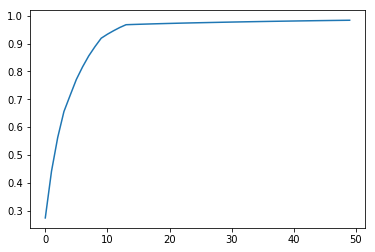

In [389]:
from sklearn.decomposition import PCA

df = pd.DataFrame(X_train_absolute)
df.cov()
pca = PCA()
pca.fit(X_train_absolute)
plt.plot(np.cumsum(pca.explained_variance_ratio_[:50]))

In [390]:
X_train_absolute_reduced = PCA(n_components=10).fit_transform(X_train_absolute)

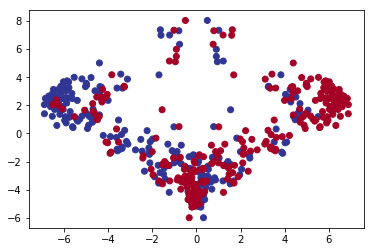

In [391]:
plt.scatter(X_train_absolute_reduced[:,0], X_train_absolute_reduced[:,1], c=y_train_absolute, cmap=plt.cm.RdYlBu)


In [392]:
X_train_absolute_reduced[0:5]

array([[ 0.08725751, -5.1919888 , -0.58324727, -2.64503472,  2.06907384,
         1.49781245,  2.59232137,  3.56409944,  0.56260398, -0.2241885 ],
       [-2.51431671, -0.42349973,  2.40611865,  0.69505253,  1.55358305,
         0.44488408,  1.63506164, -0.18522459, -3.30549021,  1.02421899],
       [ 0.53389457, -3.48824571,  2.66827729,  1.09225958,  0.2657611 ,
         1.64676467,  0.2145038 , -1.16099136, -1.28983993,  3.15046486],
       [ 0.46800323, -3.39116725,  2.68882969,  1.12507484,  1.21548425,
         0.74236017,  0.5905787 , -0.99183231, -1.80710424,  2.67780326],
       [ 5.51630977,  1.19312811,  3.37922198,  0.03699168, -3.06439248,
        -2.00884514,  1.6790483 ,  1.8964953 ,  0.66454216, -0.64327631]])

In [393]:

for pcacomp in range(2,25):
    pca.fit(X_train_absolute)
    X_train_absolute_reduced = PCA(n_components=pcacomp).fit_transform(X_train_absolute)
    lr = LogisticRegression()
    lr.fit(X_train_absolute,y_train_absolute)
    ## print 'pcacomp=' + str(pcacomp) + ' score=' + str(lr.score(X_train_absolute,y_train_absolute))
    
    logreg = LogisticRegression()
    params = {'C': np.logspace(start=-5, stop=3, num=9)}
    clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
    clf.fit(X_train_absolute_reduced, y_train_absolute)
    print 'components=' + str(pcacomp)
    print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))



components=2
Best log_loss: -0.6013, with best C: 0.01
components=3
Best log_loss: -0.4874, with best C: 0.1
components=4
Best log_loss: -0.4874, with best C: 0.1
components=5
Best log_loss: -0.4874, with best C: 0.1
components=6
Best log_loss: -0.4781, with best C: 0.1
components=7
Best log_loss: -0.4829, with best C: 0.1
components=8
Best log_loss: -0.4829, with best C: 0.1
components=9
Best log_loss: -0.4764, with best C: 0.1
components=10
Best log_loss: -0.4764, with best C: 0.1
components=11
Best log_loss: -0.4764, with best C: 0.1
components=12
Best log_loss: -0.4747, with best C: 0.1
components=13
Best log_loss: -0.4747, with best C: 0.1
components=14
Best log_loss: -0.4742, with best C: 0.1
components=15
Best log_loss: -0.4743, with best C: 0.1
components=16
Best log_loss: -0.4743, with best C: 0.1
components=17
Best log_loss: -0.4743, with best C: 0.1
components=18
Best log_loss: -0.4743, with best C: 0.1
components=19
Best log_loss: -0.4747, with best C: 0.1
components=20
Bes

In [394]:
pca.fit(X_train_absolute)
X_train_absolute_reduced = PCA(n_components=15).fit_transform(X_train_absolute)

lr = LogisticRegression()

lr.fit(X_train_absolute_reduced,y_train_absolute)
lr.score(X_train_absolute_reduced,y_train_absolute)

0.78769841269841268

In [395]:
## Fit a logistic regression model through grid search
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train_absolute_reduced, y_train_absolute)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.4743, with best C: 0.1
